In [1]:
!pip install bertopic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00


Exception ignored in: <function ZipFile.__del__ at 0x7d01f8ab4430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/zipfile.py", line 1831, in __del__
    def __del__(self):
KeyboardInterrupt: 


       Post ID                                   Post description        Date  \
0  CgXDOaQDvGm  “I have decided that the global #monkeypox out...  07/23/2022   
1  CgXpRmMIdzG  In light of the evolving monkeypox outbreak wi...  07/23/2022   
2  CgXMyIjP34S  #LinkInBio | The World Health Organization sai...  07/23/2022   
3  CgXaFGDsevq  If you've been hearing about monkeypox and wan...  07/23/2022   
4  CgX3rATJTXd  Our horrific experience with MONKEYPOX…\n\n#mo...  07/23/2022   

  Language                        Translated Post Description Sentiment  \
0  English  “I have decided that the global #monkeypox out...   neutral   
1  English  In light of the evolving monkeypox outbreak wi...   neutral   
2  English  #LinkInBio | The World Health Organization sai...      fear   
3  English  If you've been hearing about monkeypox and wan...   neutral   
4  English  Our horrific experience with MONKEYPOX…\n\n#mo...      fear   

       Hate           Stress or Anxiety  
0  Not Hate     Stre

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already b

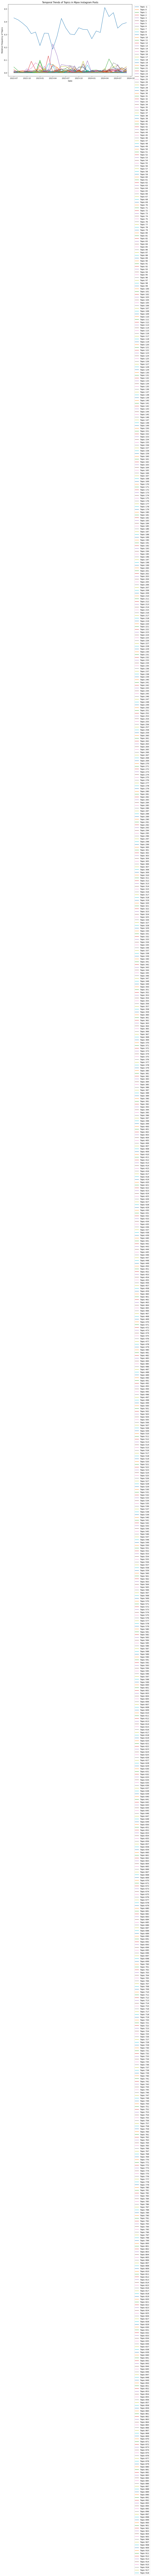

     Topic  Count                                               Name  \
0       -1  23034                -1_virus_monkeypox_symptoms_disease   
1        0    684   0_global_emergency_health emergency_world health   
2        1    671                              1_men_gay_men sex_sex   
3        2    577               2_monkeypox vaccine_got_vaccine_dose   
4        3    571            3_pakistan_karachi_islamabad_passengers   
..     ...    ...                                                ...   
915    914     10                914_rio preto_preto_riopreto_stnews   
916    915     10  915_sends_prophets generation_sends message_ge...   
917    916     10                                    916_01_02_08_07   
918    917     10  917_heaven youtube_christ obey_believe christ_...   
919    918     10  918_juazeiro_sesau_juazeiro health_department ...   

                                        Representation  \
0    [virus, monkeypox, symptoms, disease, health, ...   
1    [global, emerg

In [4]:
# Import necessary libraries
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar

# Load the dataset
data = pd.read_excel("/kaggle/input/mpox-instagram-dataset-sentiment-and-hate-analysis/Dataset.xlsx")  # Update path if necessary

# Inspect the first few rows to check column names
print(data.head())

# Assuming columns are named 'Date' and 'Translated Post Description' for post date and content
# Convert 'Date' column to datetime format if it's not already
data["Date"] = pd.to_datetime(data["Date"])

# Basic preprocessing: Lowercase, remove URLs, and any unnecessary symbols
data["Translated Post Description"] = data["Translated Post Description"].str.lower()
data["Translated Post Description"] = data["Translated Post Description"].str.replace(r"http\S+", "", regex=True)

# Initialize BERTopic model
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model)

# Use tqdm to add a progress bar when fitting the model
tqdm.pandas()  # Enable tqdm progress_apply

# Fit BERTopic on the post text content with a progress bar
topics, probabilities = topic_model.fit_transform(data["Translated Post Description"].tolist())

# Add topic results to the original dataset
data["topic"] = topics

# Group by time intervals (monthly) for temporal analysis
data["month"] = data["Date"].dt.to_period("M")  # Use 'M' for monthly, 'W' for weekly analysis
monthly_topic_counts = data.groupby(["month", "topic"]).size().unstack(fill_value=0)

# Normalize to show the relative frequency of each topic monthly
monthly_topic_dist = monthly_topic_counts.div(monthly_topic_counts.sum(axis=1), axis=0)

# Plot temporal trends for each topic
fig, ax = plt.subplots(figsize=(12, 7))
for topic in monthly_topic_dist.columns:
    ax.plot(monthly_topic_dist.index.to_timestamp(), monthly_topic_dist[topic], label=f"Topic {topic}")

ax.set_title("Temporal Trends of Topics in Mpox Instagram Posts")
ax.set_xlabel("Date")
ax.set_ylabel("Relative Frequency of Topics")
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.show()

# Output topic information and keywords for interpretation
topic_info = topic_model.get_topic_info()
print(topic_info)  # View topic keywords for interpretation

# --- Show Persistence for Each Topic ---

# Calculate persistence for each topic (number of posts per topic)
topic_persistence = data["topic"].value_counts().sort_index()

print("\nPersistence of Each Topic:")
for topic_id, count in topic_persistence.items():
    print(f"Topic {topic_id}: {count} posts")

# Show top keywords for each topic
print("\nKeywords for Topics:")
for topic_id in topic_persistence.index:
    keywords = topic_model.get_topic(topic_id)
    print(f"Topic {topic_id}: {', '.join([word for word, _ in keywords])}")


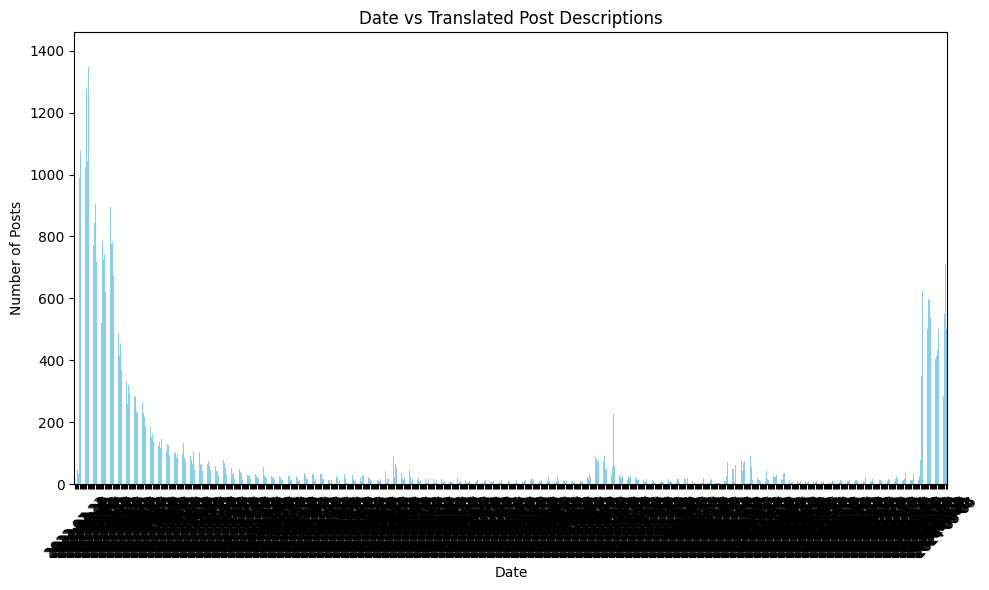

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('/kaggle/input/mpox-instagram-dataset-sentiment-and-hate-analysis/Dataset.xlsx')  # Adjust the path and file name as needed

# Convert the 'date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Group by date and count the number of translated post descriptions
date_counts = df.groupby(df['Date'].dt.date).size()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
date_counts.plot(kind='bar', color='skyblue')
plt.title('Date vs Translated Post Descriptions')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


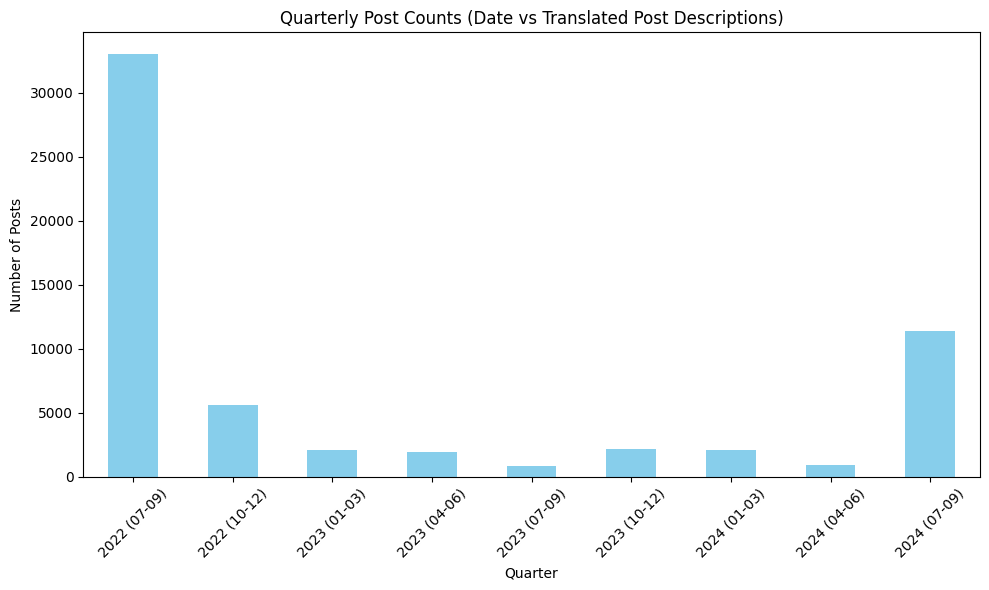

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('/kaggle/input/mpox-instagram-dataset-sentiment-and-hate-analysis/Dataset.xlsx')  # Update path if necessary

# Convert the 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Group by quarter and count the number of translated post descriptions
df['Quarter'] = df['Date'].dt.to_period('Q')
quarterly_counts = df.groupby('Quarter').size()

# Create custom labels for each quarter, e.g., '2022 (09-12)'
quarter_labels = [f"{str(q.year)} ({q.start_time.month:02}-{q.end_time.month:02})" for q in quarterly_counts.index]

# Plotting the bar chart for quarterly data
plt.figure(figsize=(10, 6))
quarterly_counts.plot(kind='bar', color='skyblue')
plt.title('Quarterly Post Counts (Date vs Translated Post Descriptions)')
plt.xlabel('Quarter')
plt.ylabel('Number of Posts')
plt.xticks(ticks=range(len(quarter_labels)), labels=quarter_labels, rotation=45)
plt.tight_layout()
plt.show()


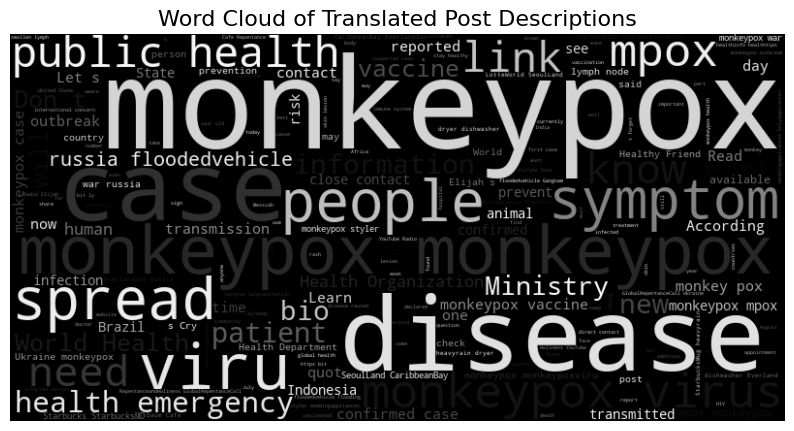

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract the text data from the relevant column (update 'Translated Post Descriptions' if the column name differs)
text_data = " ".join(df['Translated Post Description'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Greys', max_words=200).generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.title('Word Cloud of Translated Post Descriptions', fontsize=16)
plt.show()


       Post ID                                   Post description        Date  \
0  CgXDOaQDvGm  “I have decided that the global #monkeypox out...  07/23/2022   
1  CgXpRmMIdzG  In light of the evolving monkeypox outbreak wi...  07/23/2022   
2  CgXMyIjP34S  #LinkInBio | The World Health Organization sai...  07/23/2022   
3  CgXaFGDsevq  If you've been hearing about monkeypox and wan...  07/23/2022   
4  CgX3rATJTXd  Our horrific experience with MONKEYPOX…\n\n#mo...  07/23/2022   

  Language                        Translated Post Description Sentiment  \
0  English  “I have decided that the global #monkeypox out...   neutral   
1  English  In light of the evolving monkeypox outbreak wi...   neutral   
2  English  #LinkInBio | The World Health Organization sai...      fear   
3  English  If you've been hearing about monkeypox and wan...   neutral   
4  English  Our horrific experience with MONKEYPOX…\n\n#mo...      fear   

       Hate           Stress or Anxiety  
0  Not Hate     Stre

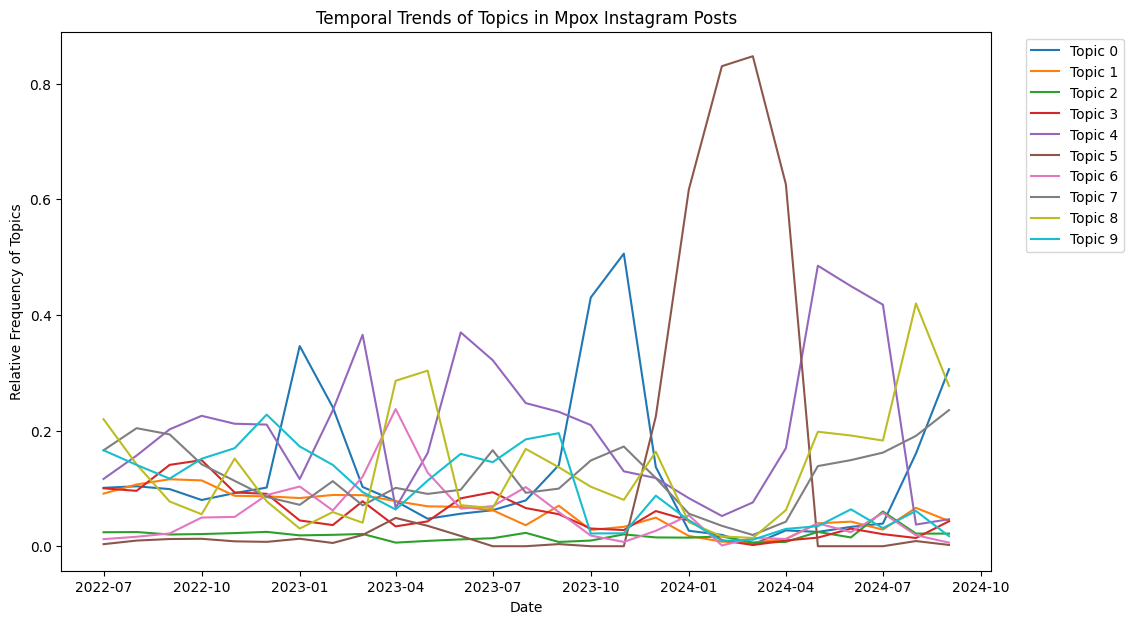


Persistence of Each Topic:
Topic 0: 7688 posts
Topic 1: 5256 posts
Topic 2: 1311 posts
Topic 3: 4756 posts
Topic 4: 8897 posts
Topic 5: 2538 posts
Topic 6: 1761 posts
Topic 7: 10408 posts
Topic 8: 10581 posts
Topic 9: 6931 posts

Keywords for Topics:
Topic 0: healthinfo, don, let, mpox, stay, health, friends, healthy, 39, monkeypox
Topic 1: smallpox, information, dr, brazil, bio, vaccine, link, news, health, monkeypox
Topic 2: people, curtis, jr, peffer, robert, states, united, dr, quot, monkeypox
Topic 3: suspected, according, case, department, disease, state, confirmed, health, cases, monkeypox
Topic 4: sex, risk, men, hiv, people, vaccination, mpox, health, vaccine, monkeypox
Topic 5: elijah, ukraine, war, repentance, holiness, floodedvehicle, russia, monkeypox, youtube, 39
Topic 6: naturally, hiv, human, cancer, lgbtq, hpv, herpes, health, herbs, monkeypox
Topic 7: fever, people, health, infected, skin, disease, virus, contact, symptoms, monkeypox
Topic 8: disease, public, outbrea

In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar

# Load the dataset
data = pd.read_excel("/kaggle/input/mpox-instagram-dataset-sentiment-and-hate-analysis/Dataset.xlsx")  # Update path if necessary

# Inspect the first few rows to check column names
print(data.head())

# Assuming columns are named 'Date' and 'Translated Post Description' for post date and content
# Convert 'Date' column to datetime format if it's not already
data["Date"] = pd.to_datetime(data["Date"])

# Basic preprocessing: Lowercase, remove URLs, and any unnecessary symbols
data["Translated Post Description"] = data["Translated Post Description"].str.lower()
data["Translated Post Description"] = data["Translated Post Description"].str.replace(r"http\S+", "", regex=True)

# Vectorize the text data
vectorizer = CountVectorizer(stop_words="english", max_df=0.95, min_df=2)
text_matrix = vectorizer.fit_transform(data["Translated Post Description"])

# Initialize the LDA model
lda_model = LDA(n_components=10, random_state=42)  # Adjust n_components for desired number of topics
tqdm.pandas()  # Enable tqdm progress_apply

# Fit the LDA model
lda_model.fit(text_matrix)

# Add topic results to the original dataset
data["topic"] = lda_model.transform(text_matrix).argmax(axis=1)

# Group by time intervals (monthly) for temporal analysis
data["month"] = data["Date"].dt.to_period("M")  # Use 'M' for monthly, 'W' for weekly analysis
monthly_topic_counts = data.groupby(["month", "topic"]).size().unstack(fill_value=0)

# Normalize to show the relative frequency of each topic monthly
monthly_topic_dist = monthly_topic_counts.div(monthly_topic_counts.sum(axis=1), axis=0)

# Plot temporal trends for each topic
fig, ax = plt.subplots(figsize=(12, 7))
for topic in monthly_topic_dist.columns:
    ax.plot(monthly_topic_dist.index.to_timestamp(), monthly_topic_dist[topic], label=f"Topic {topic}")

ax.set_title("Temporal Trends of Topics in Mpox Instagram Posts")
ax.set_xlabel("Date")
ax.set_ylabel("Relative Frequency of Topics")
ax.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.show()

# --- Show Persistence for Each Topic ---

# Calculate persistence for each topic (number of posts per topic)
topic_persistence = data["topic"].value_counts().sort_index()

print("\nPersistence of Each Topic:")
for topic_id, count in topic_persistence.items():
    print(f"Topic {topic_id}: {count} posts")

# Show top keywords for each topic
print("\nKeywords for Topics:")
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_keywords = [feature_names[i] for i in topic.argsort()[-10:]]  # Adjust number of keywords if needed
    print(f"Topic {topic_idx}: {', '.join(top_keywords)}")
